# Classifying the language of the last name via LSTM

Repeat previous RNN exercise but with LSTM

## Support code

In [1]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
#from torch.nn.functional import softmax
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)
from typing import Sequence

dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [89]:
def ctrain(model:nn.Module, train_data:TensorDataset, valid_data:TensorDataset,
           epochs=350,
           test_size=0.20,
           learning_rate = 0.002,
           batch_size=32,
           weight_decay=1.e-4,
           loss_fn=F.cross_entropy,
           metric=accuracy_score,
           print_every=30):
    "Train a regressor"
    history = []
    train_loader = DataLoader(train_data, batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#     optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for ei in range(epochs): # epochs
        for bi, (batch_x, batch_y) in enumerate(train_loader): # mini-batch
#             if len(batch_x)!=batch_size:
#                 print(f"\tBatch {bi:3d} len {len(batch_x)}")
            y_prob = model(batch_x)
#             print("y pred", y_prob, "batch_y", batch_y)
            loss = loss_fn(y_prob, batch_y)

            optimizer.zero_grad()
            loss.backward() # autograd computes U.grad and M.grad
            optimizer.step()

        with torch.no_grad():
            loss        = loss_fn(model(train_data.tensors[0]), train_data.tensors[1])
            loss_valid  = loss_fn(model(valid_data.tensors[0]), valid_data.tensors[1])
            y_prob = model(train_data.tensors[0])
            y_prob = F.softmax(y_prob, dim=1)
            y_pred = torch.argmax(y_prob, dim=1)
            metric_train = metric(y_pred.cpu(), train_data.tensors[1].cpu())
            y_prob = model(valid_data.tensors[0])
            y_prob = F.softmax(y_prob, dim=1)
            y_pred = torch.argmax(y_prob, dim=1)
            metric_valid = metric(y_pred.cpu(), valid_data.tensors[1].cpu())

        history.append( (loss, loss_valid) )
        if ei % print_every == 0:
            print(f"Epoch {ei:3d} loss {loss:7.4f}, {loss_valid:7.4f}   {metric.__class__.__name__} {metric_train:4.3f}, {metric_valid:4.3f}")

    history = torch.tensor(history)
    return model, history

In [2]:
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Sentiment log loss")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

## Load

Let's download [training](https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/names_train.csv.gz) and [testing](https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/names_test.csv.gz) data for last names.   This data set is a bunch of last names and the nationality or language. 

In [3]:
df_train = pd.read_csv("data/names_train.csv", header=None)
df_train.columns = ['name','language']
df_test = pd.read_csv("data/names_train.csv", header=None)
df_test.columns = ['name','language']

In [4]:
df_train.shape, df_test.shape

((13374, 2), (13374, 2))

In [5]:
df_train.head(2)

,name,language
0,Adsit,Czech
1,Ajdrna,Czech


## Clean

In [6]:
badname = df_train['name']=='To The First Page'
df_train[badname]

,name,language
8340,To The First Page,Russian
8341,To The First Page,Russian
8342,To The First Page,Russian
8343,To The First Page,Russian
8344,To The First Page,Russian
8345,To The First Page,Russian
8346,To The First Page,Russian
8347,To The First Page,Russian
8348,To The First Page,Russian
8349,To The First Page,Russian


In [7]:
comma = df_train['name'].str.contains(',') # might as well keep
df_train[comma]

,name,language
5976,"Jevolojnov,",Russian
6549,"Lytkin,",Russian


In [8]:
df_train[df_train['name'].str.contains("'")][:3] # there are ok so keep quote

,name,language
3609,Awak'Yan,Russian
4454,Dan'Ko,Russian
4471,Dar'Kin,Russian


In [9]:
badname = df_train['name']=='To The First Page'
df_train = df_train[~badname]

badname = df_test['name']=='To The First Page'
df_test = df_test[~badname]

In [10]:
df_train['name'] = df_train['name'].str.lower()
df_test['name'] = df_test['name'].str.lower()

In [11]:
def maxlen(strings:Sequence[str]) -> int:
    return max([len(l) for l in strings])

max_len = max(maxlen(df_train['name']), maxlen(df_test['name']))
max_len

19

## Split out validation set

In [12]:
X, y = df_train[['name']], df_train['language']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)
X_test, y_test = df_test[['name']], df_test['language']

## Get vocab

In [13]:
def vocab(strings):
    letters = [list(l) for l in strings]
    V = set([c for cl in letters for c in cl])
    V = sorted(list(V))
    ctoi = {c:i for i, c in enumerate(V)}
    return V, ctoi

In [14]:
V, ctoi = vocab(X['name'])
ctoi

{' ': 0,
 "'": 1,
 ',': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28}

## Encode target language (class)

Get categories from training only, not valid/test sets. Then apply cats to those set y's.

In [15]:
y_train = y_train.astype('category').cat.as_ordered()
y_cats = y_train.cat.categories
y_cats

Index(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German',
       'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish',
       'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'],
      dtype='object')

In [16]:
y_train = y_train.cat.codes
y_train.values[:10]

array([14,  4,  0, 14, 14, 14, 14,  5,  4, 14], dtype=int8)

In [17]:
y_valid = pd.Categorical(y_valid, categories=y_cats, ordered=True).codes
y_test = pd.Categorical(y_test, categories=y_cats, ordered=True).codes

In [18]:
y_valid[:5], y_test[:5]

(array([12, 14, 10,  8,  4], dtype=int8), array([2, 2, 2, 2, 2], dtype=int8))

## One-hot encode each letter of each name

Each name becomes a matrix of size vocab_size x max_len. Each column represents a char and we pad with zeros out to max_len number of columns since tensors have to be same length in same dimension. 

This approach is wasteful in that it expands each word to len of longest but avoids having to pad explicitly, simplifying the training process.

In [19]:
def onehot(strings:Sequence[str], V, ctoi, max_len=None) -> torch.tensor:
    if max_len is None:
        max_len = maxlen(strings)
    X_onehot = torch.zeros(len(strings),len(V),max_len)
    for i,name in enumerate(strings):
        onehot = torch.zeros((len(V),max_len))
        for j,c in enumerate(name):
            onehot[ctoi[c],j] = 1
        X_onehot[i] = onehot
    return X_onehot

In [20]:
sample = ['cat','a','at'] # always debug with a small representative example
o = onehot(sample, *vocab(sample))
o

tensor([[[0., 1., 0.],
         [1., 0., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[1., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.]]])

In [21]:
o[0,1].reshape(-1,1)

tensor([[1.],
        [0.],
        [0.]])

In [22]:
X_train_onehot = onehot(X_train['name'], V, ctoi, max_len=max_len).to(device)
X_train_onehot[0].shape

torch.Size([29, 19])

In [23]:
X_valid_onehot = onehot(X_valid['name'], V, ctoi, max_len=max_len).to(device)
X_valid_onehot[0].shape

torch.Size([29, 19])

## LSTM model

In [91]:
class LastNameLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LastNameLSTM, self).__init__()
#         print("Model: ",input_size, hidden_size, output_size)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # combine W and U into W then cat h and input
        self.W  = nn.Linear(hidden_size+input_size, hidden_size)
        self.V  = nn.Linear(hidden_size, output_size)

    def forward(self, X):
#         print("X", X.shape)
        batch_size = X.shape[0]
        namelen = X.shape[2]
        # record softmax vec of output_size for each record
        o = torch.zeros((batch_size, self.output_size)).to(device)
        # now that we do all char j in a batch, h is a matrix
        h = torch.zeros((batch_size, self.hidden_size)).to(device)
        for j in range(namelen):  # for all chars in max name length
#                 print(h.shape, X[i].shape, X[i,:,j].shape, self.U.shape)
            xj = X[:,:,j] # jth char for all records in batch
#             print("W", self.W.weight.shape, "h", h.shape, "xj", xj.shape)
            combined = torch.cat((h, xj),dim=1)
#             print("combined", combined.shape)
            h = self.W(combined)
            h = torch.relu(h)  # better than sigmoid for vanishing gradient
        # we now have an h vector that is the embedding for the ith record
        # we have encoded/embedded the X[i] record into h
        # compute an output value, one per record
        ot = self.V(h)
#         print("ot shape", ot.shape)
#             o[i] = F.softmax(ot.reshape(-1))
#         o[i] = ot.reshape(-1)
        return ot

Epoch   0 loss  1.6141,  1.6637   function 0.479, 0.481
Epoch   1 loss  1.5484,  1.6540   function 0.537, 0.516
Epoch   2 loss  1.4791,  1.6350   function 0.525, 0.502
Epoch   3 loss  1.3509,  1.4839   function 0.628, 0.581
Epoch   4 loss  1.4961,  1.8364   function 0.639, 0.580
Epoch   5 loss  1.4399,  1.6613   function 0.609, 0.567
Epoch   6 loss  1.3239,  1.5303   function 0.640, 0.594
Epoch   7 loss  1.3568,  1.5257   function 0.626, 0.596
Epoch   8 loss  1.3702,  1.5336   function 0.634, 0.589
Epoch   9 loss  1.3771,  1.6518   function 0.606, 0.560


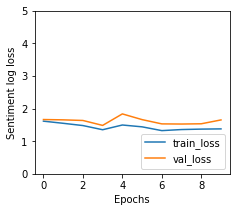

In [90]:
rnn = LastNameLSTM(input_size=len(V),
                   hidden_size=100,
                   output_size=len(y_cats)).to(device)
subset=1000
train = TensorDataset(X_train_onehot[:subset].double().to(device), torch.tensor(y_train[:subset].values).long().to(device))
valid = TensorDataset(X_valid_onehot[:subset].double().to(device), torch.tensor(y_valid[:subset]).long().to(device))
model, history = ctrain(rnn, train, valid,
#                         loss_fn=torch.nn.BCELoss(),
                        loss_fn=F.cross_entropy,
                        metric=accuracy_score,
                        epochs=10,
                        learning_rate=.02,
                        weight_decay=0.00001,
                        batch_size=32,
                        print_every=1)

plot_history(history, yrange=(0,5))